<a href="https://colab.research.google.com/github/Sahil9424r/Song_Recommendation/blob/main/SongRecommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [ ]:
!kaggle datasets download -d vatsalmavani/spotify-dataset

Dataset URL: https://www.kaggle.com/datasets/vatsalmavani/spotify-dataset
License(s): unknown
100% 16.5M/16.5M [00:00<00:00, 41.0MB/s]
100% 16.5M/16.5M [00:00<00:00, 38.8MB/s]


In [ ]:
!unzip -o spotify-dataset.zip

Archive:  spotify-dataset.zip
  inflating: data/data.csv           
  inflating: data/data_by_artist.csv  
  inflating: data/data_by_genres.csv  
  inflating: data/data_by_year.csv   
  inflating: data/data_w_genres.csv  


In [ ]:
df=pd.read_csv("data/data.csv")

In [ ]:
df.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339
3,0.1650,1921,0.967,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,0.381,-9.316,1,Danny Boy,3,1921,0.0354,100.109
4,0.2530,1921,0.957,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,0.229,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665


In [ ]:
from sklearn.preprocessing import StandardScaler

numerical_features = [
    "valence", "danceability", "energy", "tempo",
    "acousticness", "liveness", "speechiness", "instrumentalness"
]

# Standardize the numerical features
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[numerical_features]), columns=numerical_features)

In [ ]:


from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(df_scaled, test_size=0.2, random_state=42)

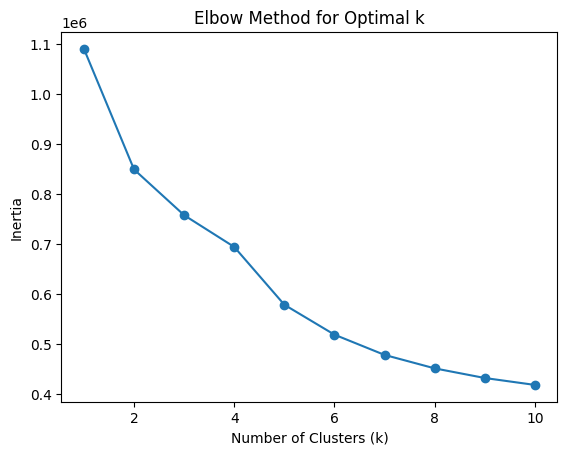

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


inertia = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(train_data)
    inertia.append(kmeans.inertia_)


plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

In [ ]:
inertia # so after 5  value not change much

[1089944.080282759,
 848827.1543647622,
 757311.0421438267,
 693801.0716009749,
 578196.576477181,
 518345.8629151229,
 477827.38472841366,
 450925.2541237246,
 431652.0791882542,
 417802.5514779103]

In [ ]:
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df["Cluster"] = kmeans.fit_predict(df_scaled)

In [ ]:
df.Cluster.value_counts()

,count
Cluster,
2,55416
0,47056
3,37278
1,25094
4,5809


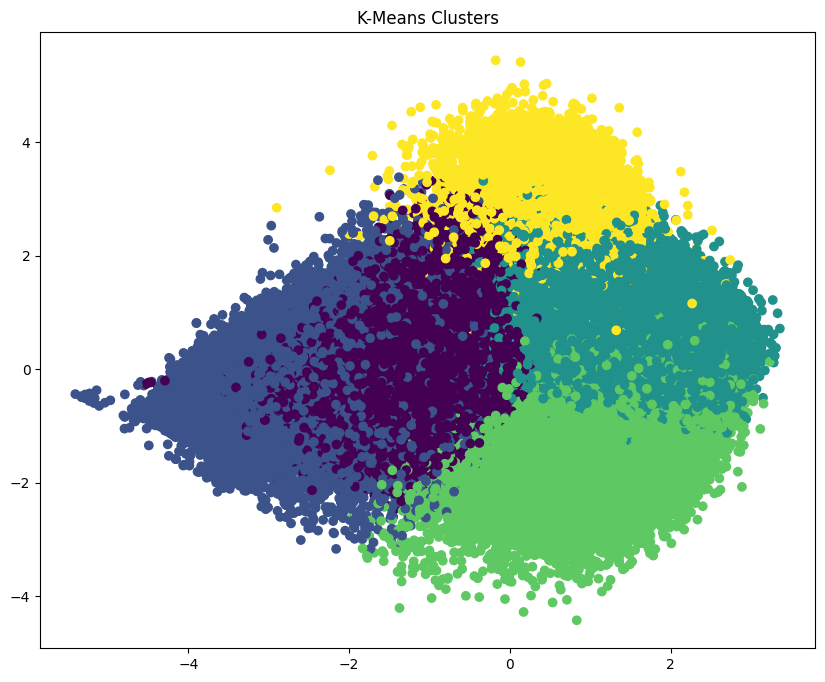

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled)
plt.figure(figsize=(10,8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=df["Cluster"], cmap="viridis")
plt.title("K-Means Clusters")
plt.show()

In [ ]:
df_scaled.head()

,valence,danceability,energy,tempo,acousticness,liveness,speechiness,instrumentalness
0,-1.782825,-1.467013,-1.013988,-1.169307,1.276187,2.626719,-0.379706,2.268102
1,1.650688,1.598779,-0.528270,-1.821180,0.611347,-0.262229,1.945481,-0.532771
2,-1.858821,-1.188820,-1.182122,-0.212404,1.220340,-0.599749,-0.396297,2.379754
3,-1.381564,-1.489722,-0.647832,-0.545537,1.236296,1.002043,-0.387080,-0.532682
4,-1.047180,-0.677855,-1.081242,-0.494867,1.209703,0.132499,-0.371104,-0.532765


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def recommend_songs(song_name, df, num_recommendations=5):
    # Get the cluster of the input song
    song_cluster = df[df["name"] == song_name]["Cluster"].values[0]

    # Filter songs from the same cluster
    same_cluster_songs = df[df["Cluster"] == song_cluster]

    # Calculate similarity within the cluster
    song_index = same_cluster_songs[same_cluster_songs["name"] == song_name].index[0]
    cluster_features = same_cluster_songs[numerical_features]
    similarity = cosine_similarity(cluster_features, cluster_features)

    sorted_indices = np.argsort(similarity[song_index])[::-1]

    # Exclude the input song itself (first index) and select the top recommendations
    top_indices = sorted_indices[1:num_recommendations + 1]
    similar_songs = same_cluster_songs.iloc[top_indices].index
    recommendations = same_cluster_songs.iloc[similar_songs][["name", "year", "artists"]]

    return recommendations

In [ ]:
input_song =  "Camby Bolongo"
recommended_songs = recommend_songs(input_song, df, num_recommendations=5)

print(f"Songs similar to '{input_song}':")
recommended_songs

In [ ]:
# Example usage
input_song = "Soul Junction"
recommended_songs = recommend_songs(input_song, df, num_recommendations=5)

print(f"Songs similar to '{input_song}':")
recommended_songs